# Radio telescope noise calculation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [2]:
from tqdm import tqdm
from glob import glob
from time import time

In [3]:
from astropy import units as un
from astropy.cosmology import Planck15

In [4]:
import tools21cm as t2c

t2c.set_hubble_h(0.67)
t2c.set_ns(0.96)
t2c.set_omega_baryon(0.049)
t2c.set_omega_matter(0.31)

## SKA-Low antennae distribution

In [5]:
aastar_layout = t2c.get_SKA_Low_layout(subarray_type="AA*")
aa4_layout = t2c.get_SKA_Low_layout(subarray_type="AA4")

AA* contains 307 antennae.
AA4 contains 512 antennae.


(307, 3)
(512, 3)


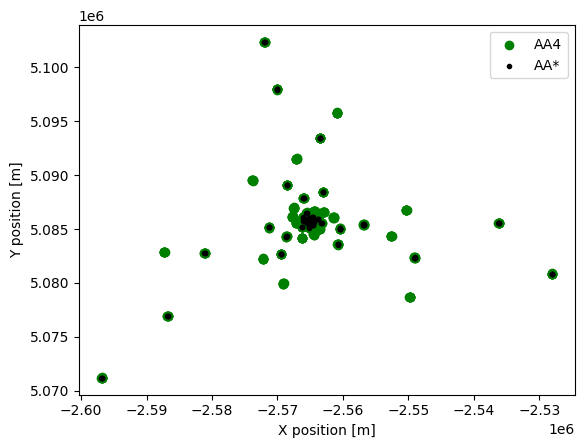

In [6]:
print(aastar_layout.shape)
print(aa4_layout.shape)

plt.scatter(aa4_layout[:, 0], aa4_layout[:, 1], label="AA4", color="g")
plt.scatter(aastar_layout[:, 0], aastar_layout[:, 1], label="AA*", color="k", marker=".")
plt.legend()
plt.ylabel("Y position [m]")
plt.xlabel("X position [m]")
plt.show()

In [7]:
aastar_baselines = t2c.antenna_positions_to_baselines(aastar_layout)
aa4_baselines = t2c.antenna_positions_to_baselines(aa4_layout)
print(aastar_baselines.shape, aa4_baselines.shape)

93942it [00:00, 218544.50it/s]
261632it [00:01, 233418.26it/s]


(93942, 3) (261632, 3)


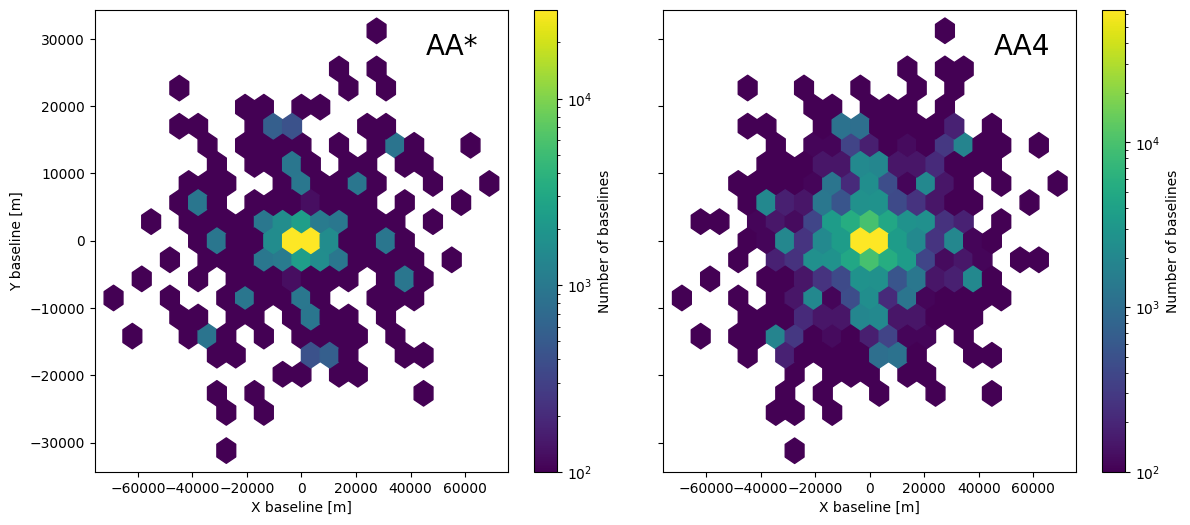

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True, gridspec_kw={"wspace": 0.1})
im = ax[0].hexbin(
    aastar_baselines[:, 0], 
    aastar_baselines[:, 1],
    label="AA*",
    gridsize=20,
    bins="log",
    vmin=100,
)
plt.colorbar(im, ax=ax[0], label="Number of baselines")
im = ax[1].hexbin(
    aa4_baselines[:, 0], 
    aa4_baselines[:, 1],
    label="AA4",
    gridsize=20,
    bins="log",
    vmin=100,
)
plt.colorbar(im, ax=ax[1], label="Number of baselines")
ax[0].set_xlabel("X baseline [m]")
ax[1].set_xlabel("X baseline [m]")
ax[0].set_ylabel("Y baseline [m]")
ax[0].text(0.8, 0.95, "AA*", transform=ax[0].transAxes, fontsize=20, verticalalignment="top")
ax[1].text(0.8, 0.95, "AA4", transform=ax[1].transAxes, fontsize=20, verticalalignment="top")
plt.show()

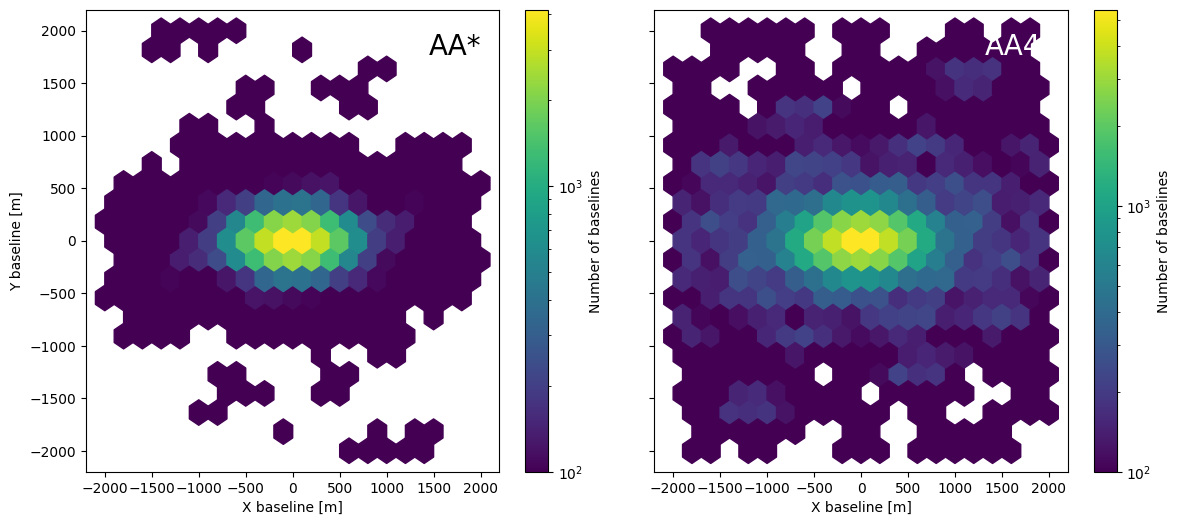

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True, gridspec_kw={"wspace": 0.1})
m = np.logical_and(
    abs(aastar_baselines[:,0].value) < 2000,
    abs(aastar_baselines[:,1].value) < 2000,
)
im = ax[0].hexbin(
    aastar_baselines[:,0][m],
    aastar_baselines[:,1][m],
    label="AA*",
    gridsize=20,
    bins="log",
    vmin=100,
)
plt.colorbar(im, ax=ax[0], label="Number of baselines")
m = np.logical_and(
    abs(aa4_baselines[:,0].value) < 2000,
    abs(aa4_baselines[:,1].value) < 2000,
)
im = ax[1].hexbin(
    aa4_baselines[:,0][m],
    aa4_baselines[:,1][m],
    label="AA4",
    gridsize=20,
    bins="log",
    vmin=100,
)
plt.colorbar(im, ax=ax[1], label="Number of baselines")
ax[0].set_xlabel("X baseline [m]")
ax[1].set_xlabel("X baseline [m]")
ax[0].set_ylabel("Y baseline [m]")
ax[0].text(0.83, 0.95, "AA*", transform=ax[0].transAxes, fontsize=20, verticalalignment="top")
ax[1].text(
    0.8, 0.95, "AA4", transform=ax[1].transAxes, fontsize=20, verticalalignment="top", color="w"
)
plt.show()

## $uv$ tracks

In [10]:
boxsize = 128 #512.
ncells = 256
redshift = 6.
total_int_time = 4. #hours
int_time = 10.      #seconds
obs_time = 1000     #hours
declination = -27.  #-30.

In [11]:
uv_map_AAstar, N_ant_AAstar = t2c.get_uv_map(ncells, redshift, 
                                             subarray_type="AA*", 
                                             total_int_time=total_int_time, 
                                             int_time=int_time, 
                                             boxsize=boxsize, 
                                             declination=declination
                                             )

uv_map_AA4, N_ant_AA4 = t2c.get_uv_map(ncells, redshift, 
                                        subarray_type="AA4", 
                                        total_int_time=total_int_time, 
                                        int_time=int_time, 
                                        boxsize=boxsize, 
                                        declination=declination
                                        )

# uv_map, N_ant = t2c.get_uv_map(ncells, redshift, 
#                                 subarray_type=None, 
#                                 total_int_time=total_int_time, 
#                                 int_time=int_time, 
#                                 boxsize=boxsize, 
#                                 declination=declination
#                                 )

AA* contains 307 antennae.
Generating uv map from daily observations...


Gridding uv tracks: 1440it [00:01, 797.11it/s]


...done
AA4 contains 512 antennae.
Generating uv map from daily observations...


Gridding uv tracks: 1440it [00:05, 268.82it/s]

...done


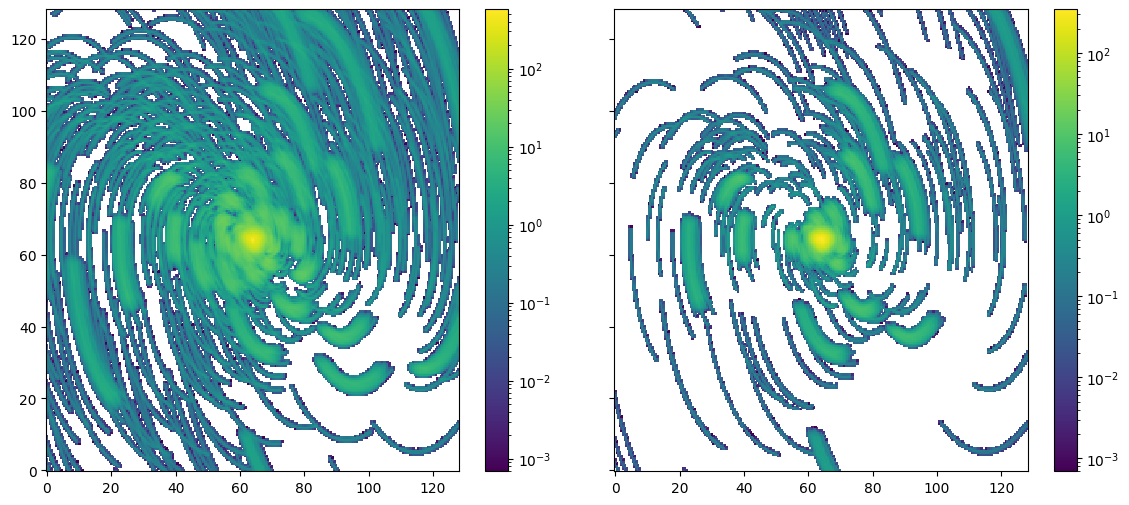

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True, gridspec_kw={"wspace": 0.1})
xx = np.linspace(0, boxsize, ncells)
im0 = axs[0].pcolor(xx, xx,
              np.fft.fftshift(uv_map_AA4),
              norm=LogNorm(),
              )
fig.colorbar(im0, ax=axs[0])
im1 = axs[1].pcolor(xx, xx,
              np.fft.fftshift(uv_map_AAstar), #np.fft.fftshift(uv_map), #
              norm=LogNorm(),
              )
fig.colorbar(im1, ax=axs[1])

## Noise Maps

In [13]:
noise_cube_AA4 = t2c.noise_cube_coeval(ncells, redshift, 
                                   depth_mhz=None, 
                                   obs_time=obs_time, 
                                   subarray_type="AA4", 
                                   boxsize=boxsize, 
                                   total_int_time=total_int_time, 
                                   int_time=int_time, 
                                   declination=declination, 
                                   uv_map=uv_map_AA4, 
                                   N_ant=N_ant_AA4, 
                                   )

noise_cube_AAstar = t2c.noise_cube_coeval(ncells, redshift, 
                                   depth_mhz=None, 
                                   obs_time=obs_time, 
                                   subarray_type="AAstar", 
                                   boxsize=boxsize, 
                                   total_int_time=total_int_time, 
                                   int_time=int_time, 
                                   declination=declination, 
                                   uv_map=uv_map_AAstar, 
                                   N_ant=N_ant_AAstar, 
                                   )

# noise_cube = t2c.noise_cube_coeval(ncells, redshift, 
#                                    depth_mhz=None, 
#                                    obs_time=obs_time, 
#                                    subarray_type=None, 
#                                    boxsize=boxsize, 
#                                    total_int_time=total_int_time, 
#                                    int_time=int_time, 
#                                    declination=declination, 
#                                    )

AA4 contains 512 antennae.
Creating the noise cube...


100%|██████████| 256/256 [00:01<00:00, 241.73it/s]


...noise cube created.
AAstar contains 307 antennae.
Creating the noise cube...


100%|██████████| 256/256 [00:01<00:00, 234.03it/s]

...noise cube created.


100%|██████████| 256/256 [00:00<00:00, 1249.51it/s]


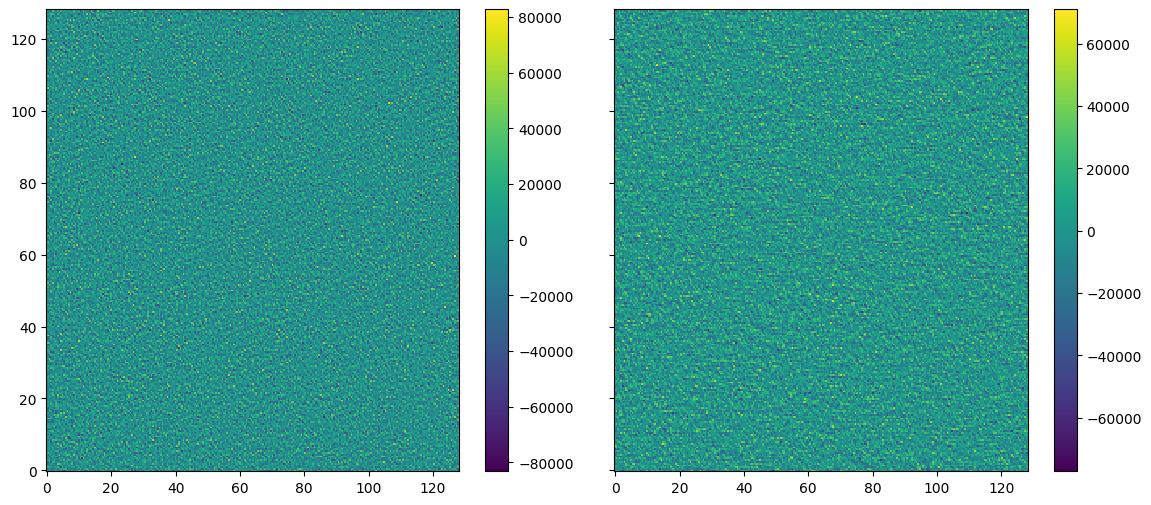

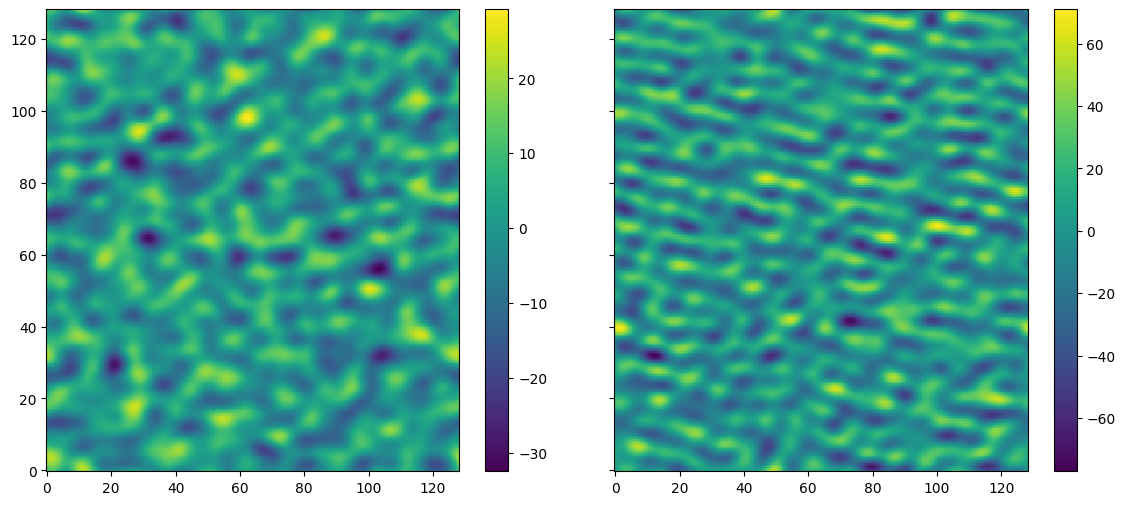

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True, gridspec_kw={"wspace": 0.1})
xx = np.linspace(0, boxsize, ncells)
im0 = axs[0].pcolor(xx, xx,
              noise_cube_AA4[:,:,10],
              )
fig.colorbar(im0, ax=axs[0])
im1 = axs[1].pcolor(xx, xx,
              noise_cube_AAstar[:,:,10],
              )
fig.colorbar(im1, ax=axs[1])

fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True, gridspec_kw={"wspace": 0.1})
xx = np.linspace(0, boxsize, ncells)
im0 = axs[0].pcolor(xx, xx,
              t2c.smooth_coeval(noise_cube_AA4, redshift, box_size_mpc=boxsize)[:,:,10],
              )
fig.colorbar(im0, ax=axs[0])
im1 = axs[1].pcolor(xx, xx,
              t2c.smooth_coeval(noise_cube_AAstar, redshift, box_size_mpc=boxsize)[:,:,10],
              )
fig.colorbar(im1, ax=axs[1])

In [15]:
ps_AA4, ks_AA4 = t2c.power_spectrum_1d(noise_cube_AA4, kbins=10, box_dims=boxsize)
ps_AAstar, ks_AAstar = t2c.power_spectrum_1d(noise_cube_AAstar, kbins=10, box_dims=boxsize)

(0.07, 2.0, 0.02, 1000.0)

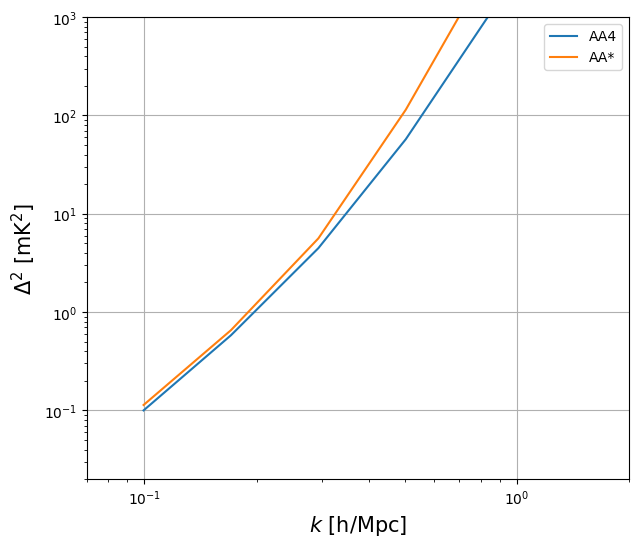

In [16]:
hlittle = 0.67

fig, ax = plt.subplots(1, 1, figsize=(7, 6), sharey=True, gridspec_kw={"wspace": 0.1})
ax.loglog(ks_AA4/hlittle, ps_AA4*ks_AA4**3/2/np.pi**2, label='AA4')
ax.loglog(ks_AAstar/hlittle, ps_AAstar*ks_AAstar**3/2/np.pi**2, label='AA*')
ax.set_xlabel(r'$k$ [h/Mpc]' if hlittle!=1 else r'$k$ [1/Mpc]', fontsize=15)
ax.set_ylabel(r'$\Delta^2$ [mK$^2$]', fontsize=15)
ax.legend()
ax.grid()  
ax.axis([7e-2,2,2e-2,1e3])